In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS
import clustering as clstr
import bout as bt
import plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline

from cli import get_file_paths

In [4]:
site_key = 'Carp'
freq_key = 'LF'

bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 2000
print(f'Looking at {fig_details["site_name"]}')

Looking at Carp Pond


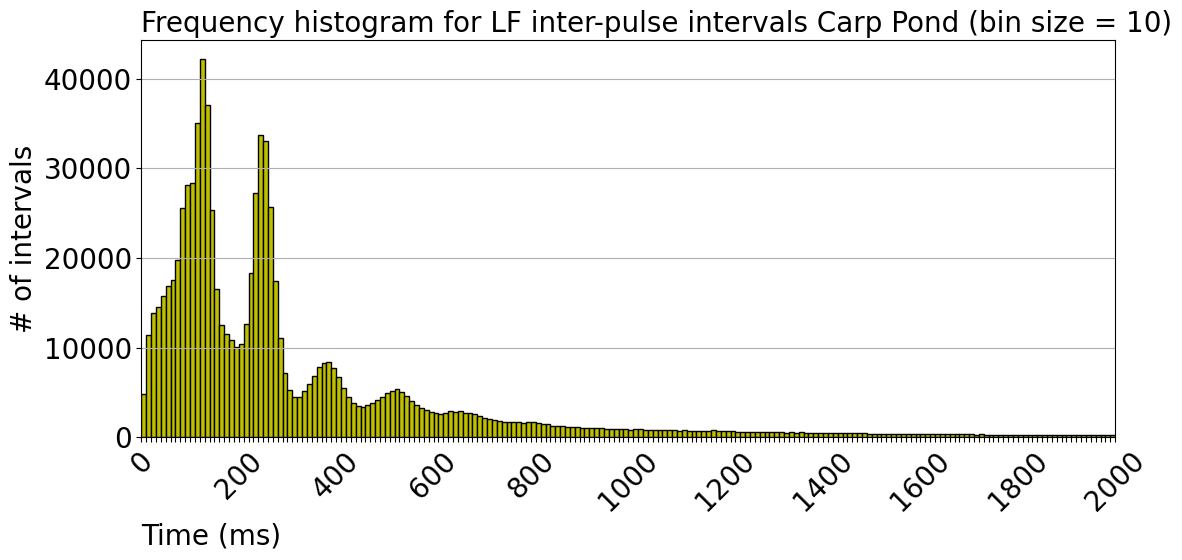

In [5]:
location_df = pd.read_csv(f'../data/2022_bd2_summary/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022.csv', index_col=0)
ipis_f, hist_f = bt_plt.plot_ipi_hist(location_df, fig_details)

In [6]:
location_df = pd.read_csv(f'../data/2022_bd2_summary/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022.csv', index_col=0)
ipis_loc, hist_loc = clstr.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = clstr.get_log_survival(hist_loc)

fast_process = clstr.regress_around_fast_intervals(intervals_ms, survival, hist_loc[0])
fast_process = clstr.calculate_exponential_coefficients(fast_process)

slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
slow_process = clstr.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = clstr.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = clstr.get_bci_from_slater_method(fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")

Fagen&Young method has 2025268543 missassigned points
Slater method has 3844983 missassigned points
Sibly method has 3809258 missassigned points
Optim BCI has less misassignments than BCI? True
35724 more points assigned correctly


In [7]:
fast_process, slow_process

({'metrics': LinregressResult(slope=-0.00136380126754839, intercept=13.048469351868626, rvalue=-0.9432242501243998, pvalue=3.344433636658395e-97, stderr=3.404493379145311e-05, intercept_stderr=0.03936081233336167),
  'indices': array([ True,  True,  True, ..., False, False, False]),
  'lambda': 0.00136380126754839,
  'num_intervals_slater': 340507864.54066104},
 {'metrics': LinregressResult(slope=-3.455847710122454e-07, intercept=6.550940275962139, rvalue=-0.9882479394582755, pvalue=0.0, stderr=4.3992857973728146e-11, intercept_stderr=0.00037727806749035997),
  'indices': array([False, False, False, ..., False, False, False]),
  'lambda': 3.455847710122454e-07,
  'num_intervals_slater': 2025268542.5301468})

In [8]:
nlin_results

{'solution': array([6.01473398e+08, 1.49830618e-03, 2.02526854e+09, 3.45584771e-07]),
 'fast_num_intervals': 601473398.3378534,
 'fast_lambda': 0.0014983061754729082,
 'slow_num_intervals': 2025268541.21566,
 'slow_lambda': 3.4558477091943737e-07,
 'bci': 4780.1875503217325}

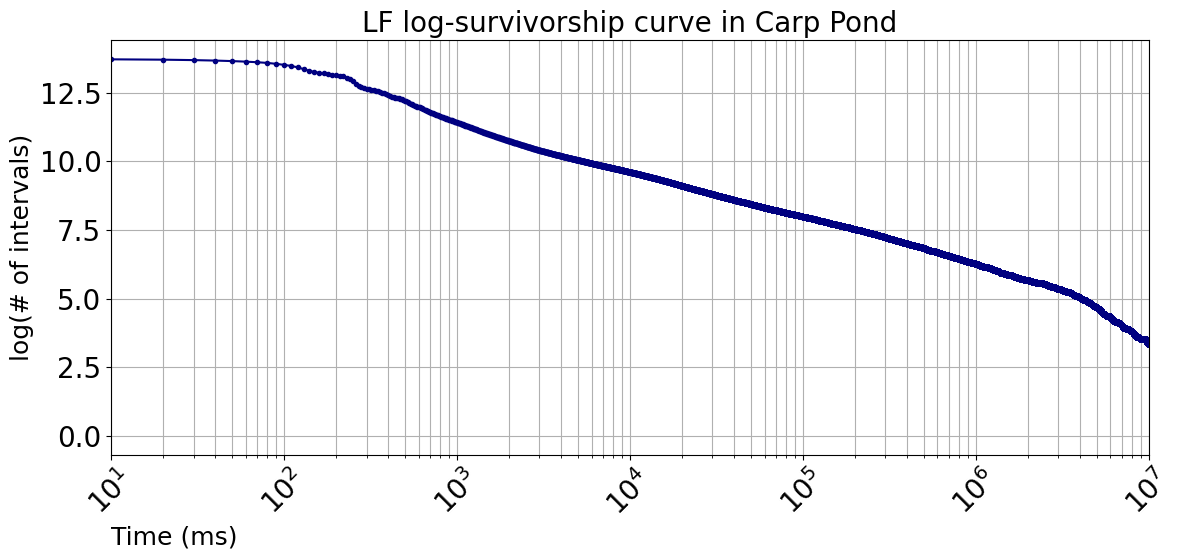

In [9]:
bt_plt.plot_log_survival(intervals_ms, survival, fig_details)

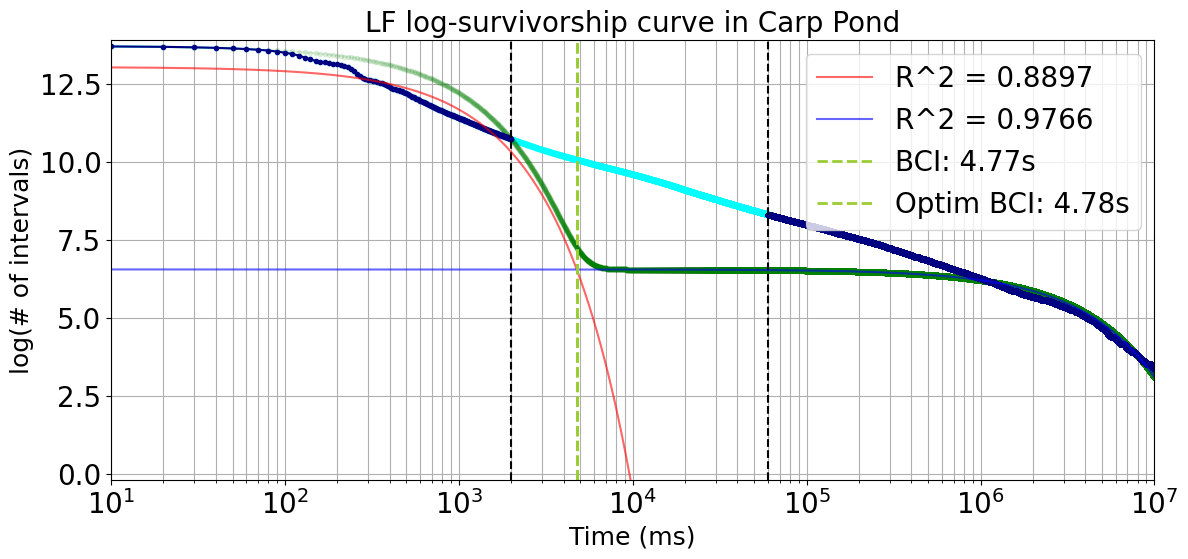

In [10]:
fig_details['time_end'] = 60000
fig_details['site_name'] = SITE_NAMES[site_key]
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

Fagen&Young method has 280834159 missassigned points
Slater method has 535335 missassigned points
Sibly method has 888410 missassigned points
Optim BCI has less misassignments than BCI? False


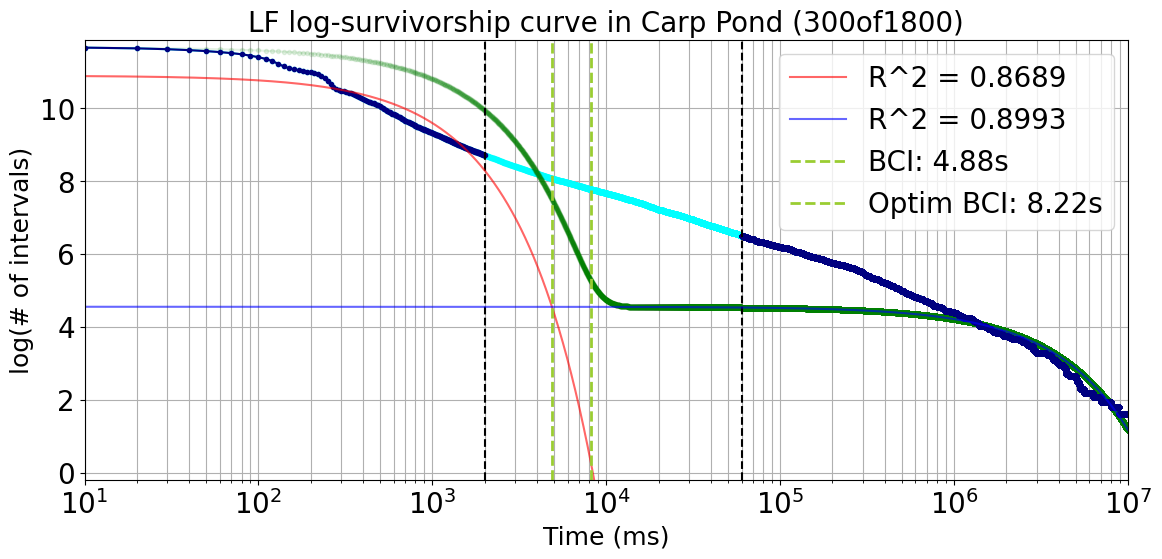

In [11]:
data_params = dict()
data_params['type_tag'] = freq_key
data_params['site_tag'] = site_key
data_params['cur_dc_tag'] = '300of1800'
data_params['bin_size'] = '30'
fig_details['site_name'] = SITE_NAMES[site_key] + ' ' + f"({data_params['cur_dc_tag']})"

file_paths = get_file_paths(data_params)

location_df = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, data_params['cur_dc_tag'], data_params['bin_size'])
ipis_loc, hist_loc = clstr.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = clstr.get_log_survival(hist_loc)

fast_process = clstr.regress_around_fast_intervals(intervals_ms, survival, hist_loc[0])
fast_process = clstr.calculate_exponential_coefficients(fast_process)

slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
slow_process = clstr.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = clstr.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = clstr.get_bci_from_slater_method(fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

Fagen&Young method has 1531407524 missassigned points
Slater method has 628097 missassigned points
Sibly method has 552506 missassigned points
Optim BCI has less misassignments than BCI? True
75590 more points assigned correctly


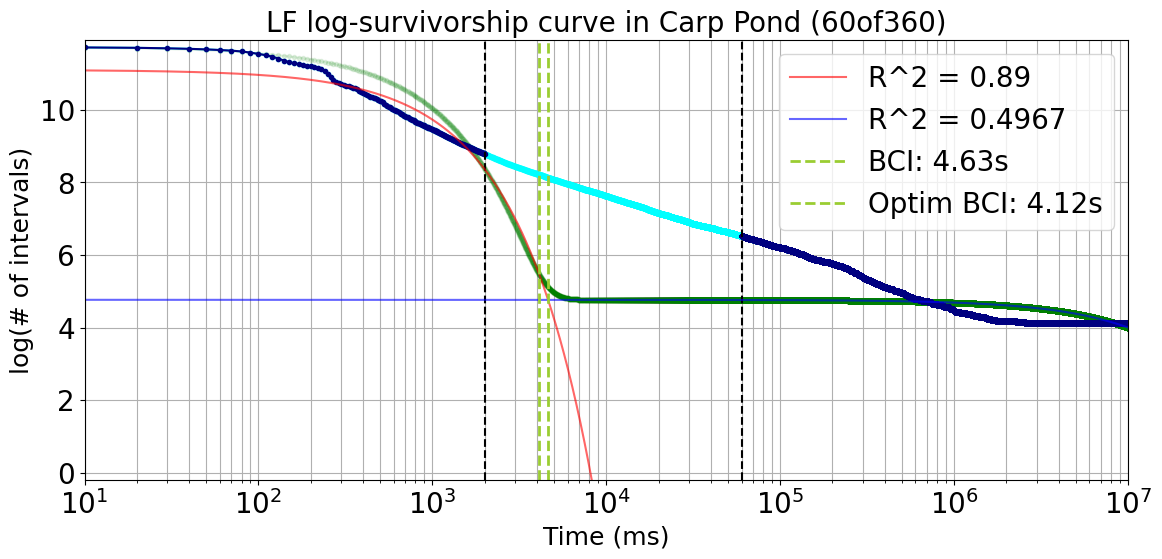

In [12]:
data_params = dict()
data_params['type_tag'] = freq_key
data_params['site_tag'] = site_key
data_params['cur_dc_tag'] = '60of360'
data_params['bin_size'] = '30'
fig_details['site_name'] = SITE_NAMES[site_key] + ' ' + f"({data_params['cur_dc_tag']})"

file_paths = get_file_paths(data_params)

location_df = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, data_params['cur_dc_tag'], data_params['bin_size'])
ipis_loc, hist_loc = clstr.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = clstr.get_log_survival(hist_loc)

fast_process = clstr.regress_around_fast_intervals(intervals_ms, survival, hist_loc[0])
fast_process = clstr.calculate_exponential_coefficients(fast_process)

slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
slow_process = clstr.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = clstr.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = clstr.get_bci_from_slater_method(fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

In [13]:
files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
files_from_loc

[PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_030000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_033000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_040000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_043000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_050000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_053000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_060000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_063000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_070000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_073000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_080000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220

In [14]:
file_path = Path(files_from_loc[8])
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 660
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True

data_params = dict()
data_params['site_tag'] = bout_params['site_key']
data_params['type_tag'] = ''
data_params['cur_dc_tag'] = '1800of1800'
data_params['bin_size'] = '30'

file_paths = get_file_paths(data_params)

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
csv_path = Path(f'../data/raw/{site_key}/bd2__{site_key}_{filename.split(".")[0]}.csv')


In [15]:
batdetect2_predictions_no_dutycycle = actvt.assemble_single_bd2_output_use_kmeans_to_group(csv_path, file_paths)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['cur_dc_tag'], data_params['bin_size'])
location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
bout_params = bt.get_bout_params_from_location(location_df, data_params)
batdetect2_preds_with_bouttags = bt.classify_bouts_in_bd2_predictions_for_freqgroups(batdetect2_predictions, bout_params)
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

In [16]:
bout_params

{'site_key': 'Carp', 'LF_bci': 2275.044968074372, 'HF_bci': 1653.9303117495783}

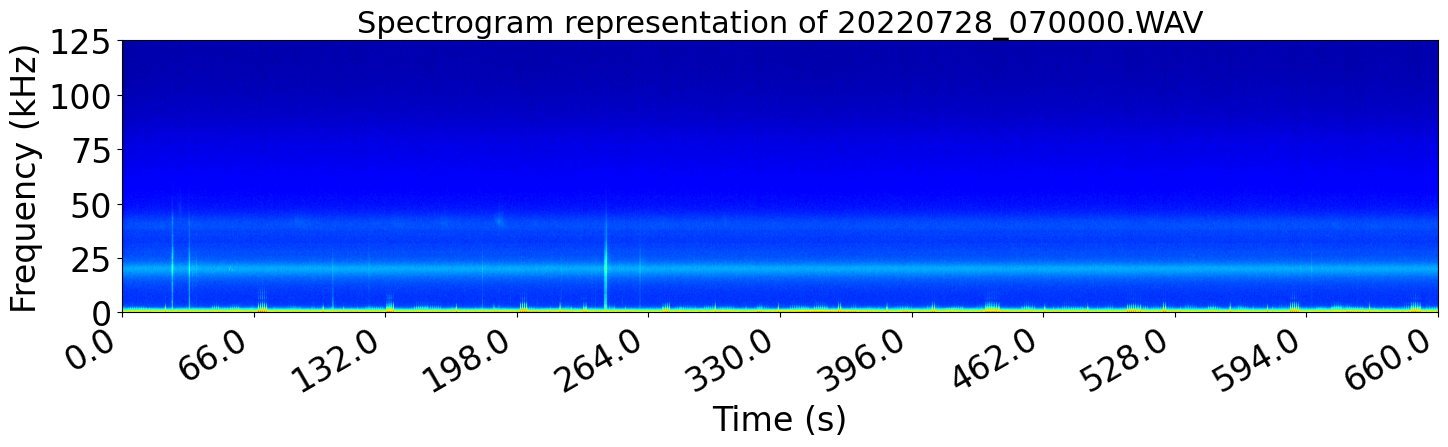

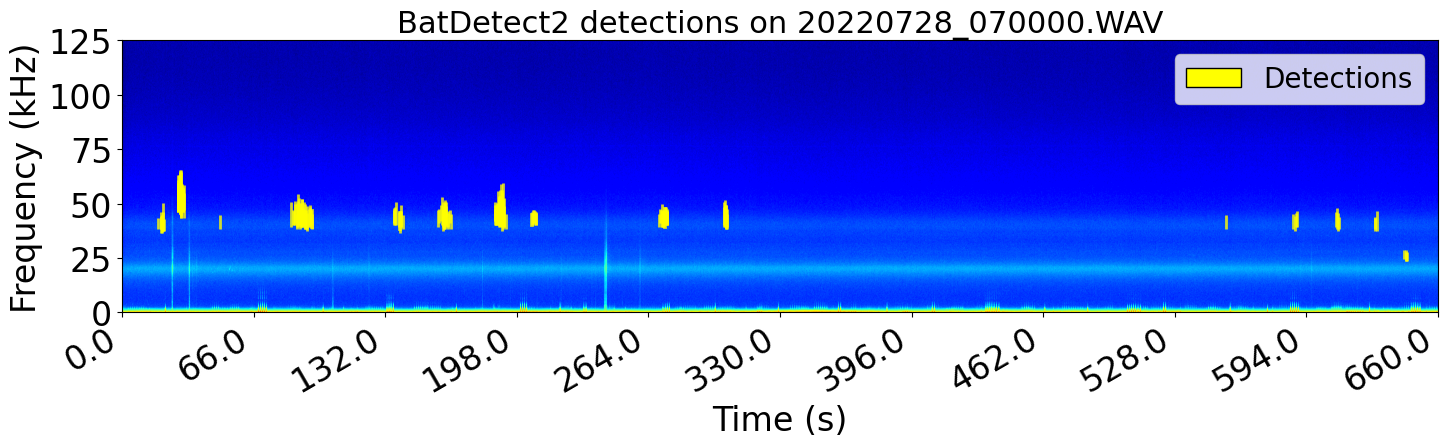

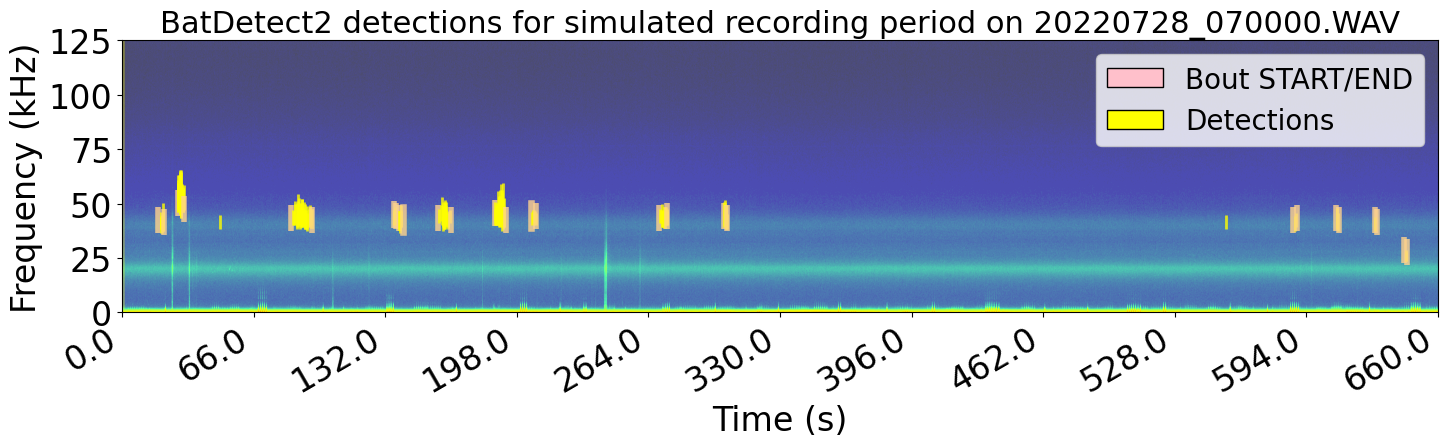

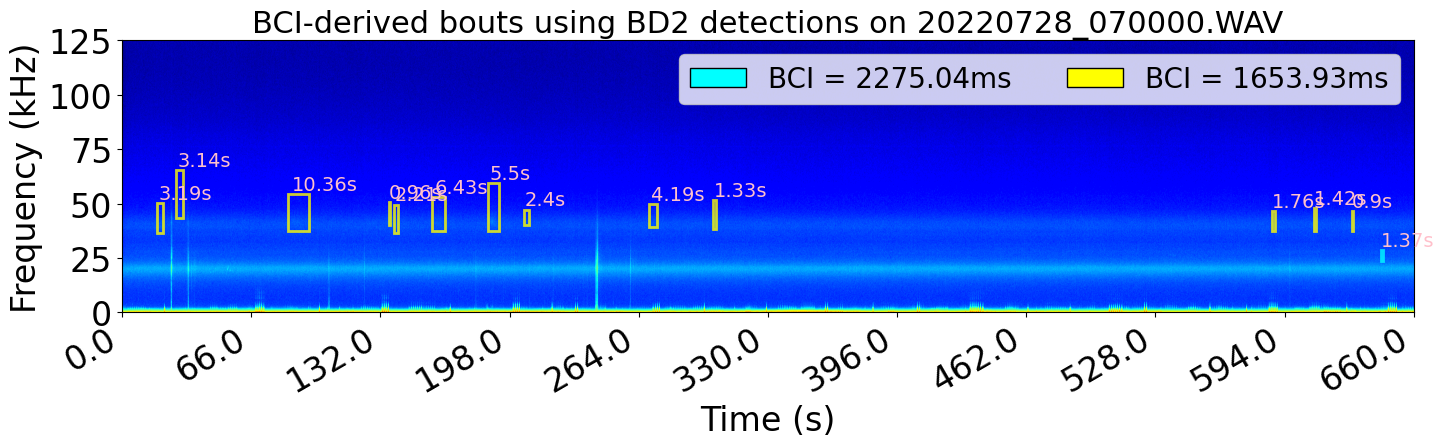

In [17]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

In [19]:
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 600
duration = 660
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

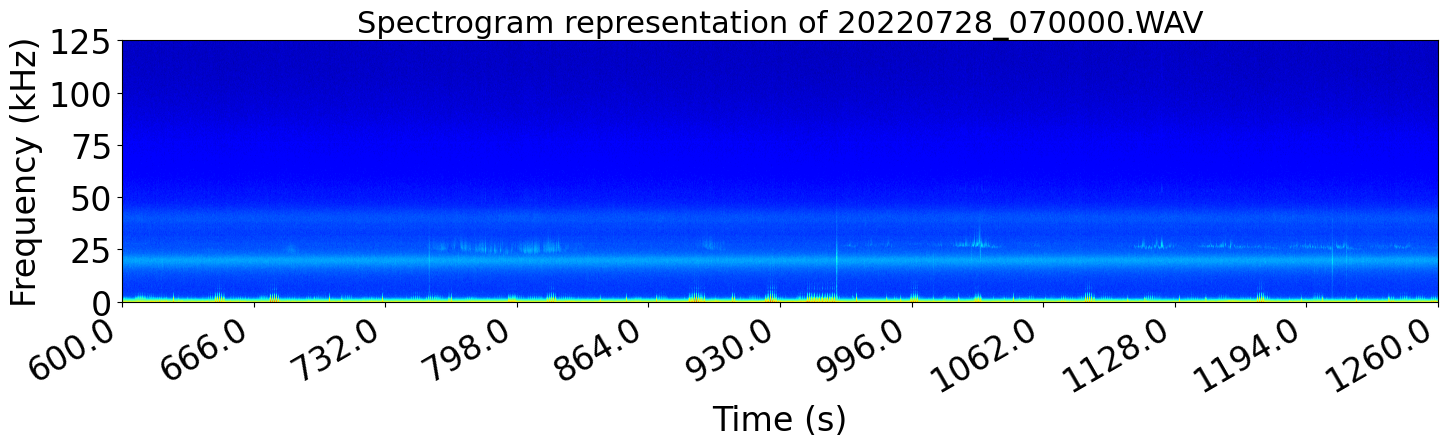

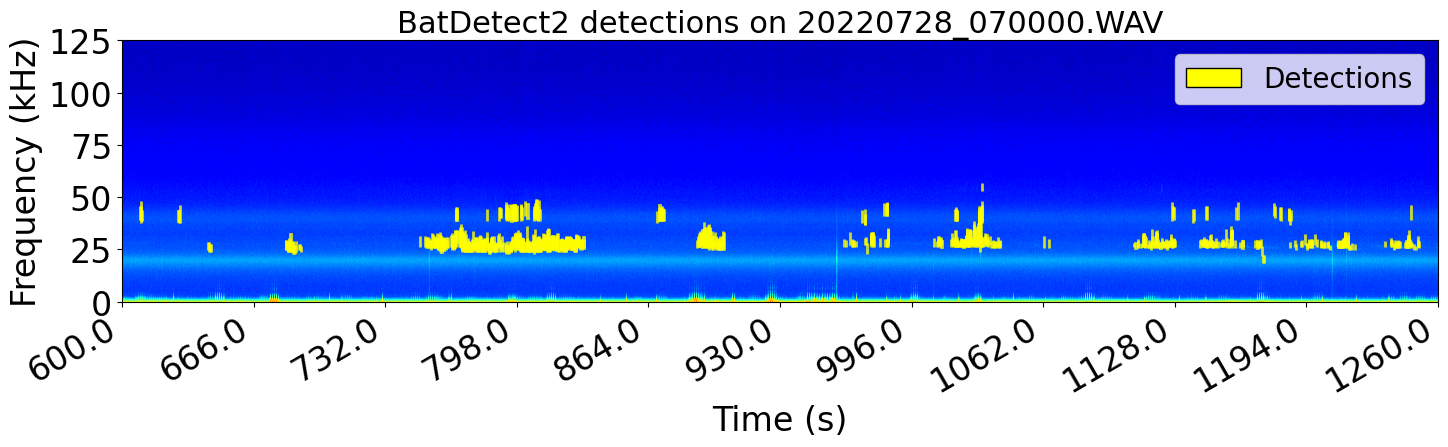

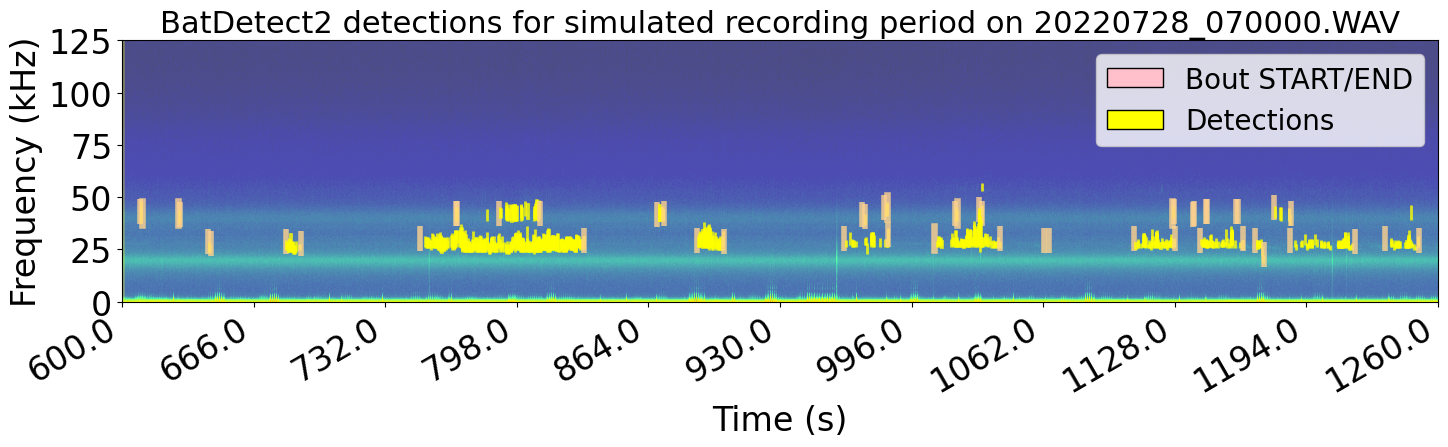

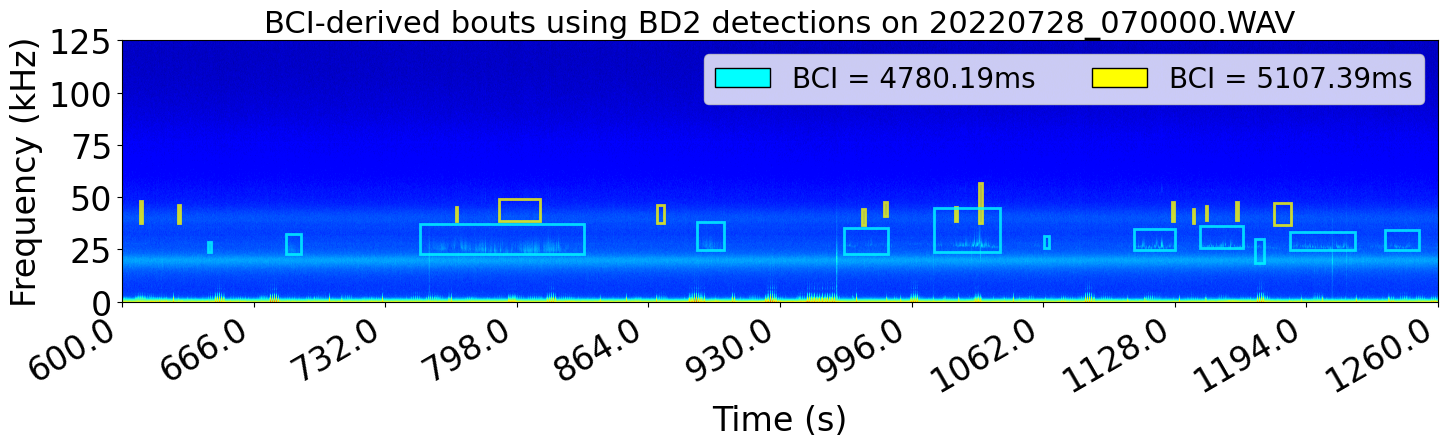

In [20]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

In [21]:
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 1200
duration = 600
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 55 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

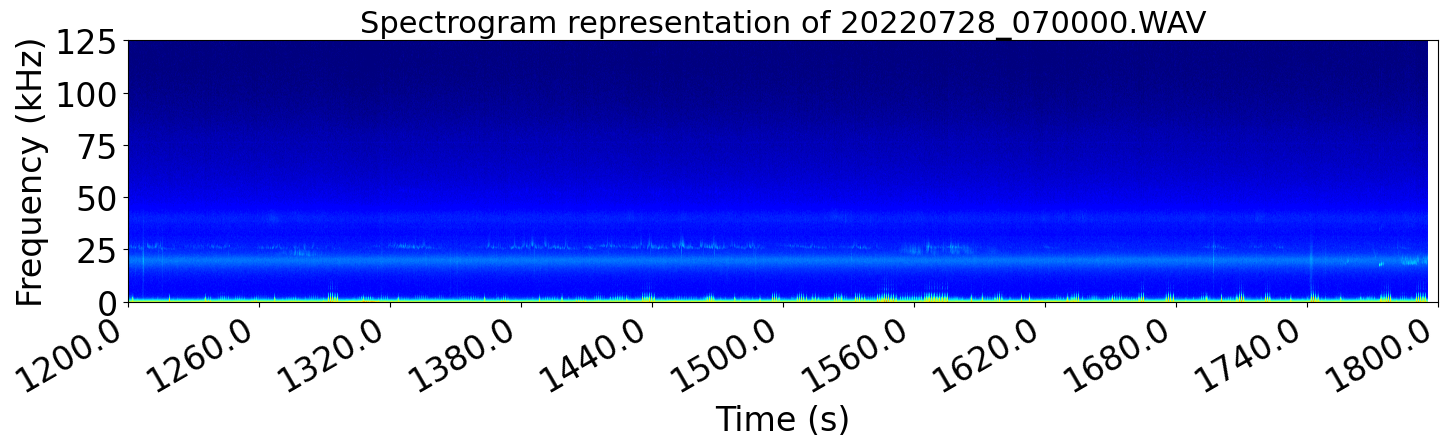

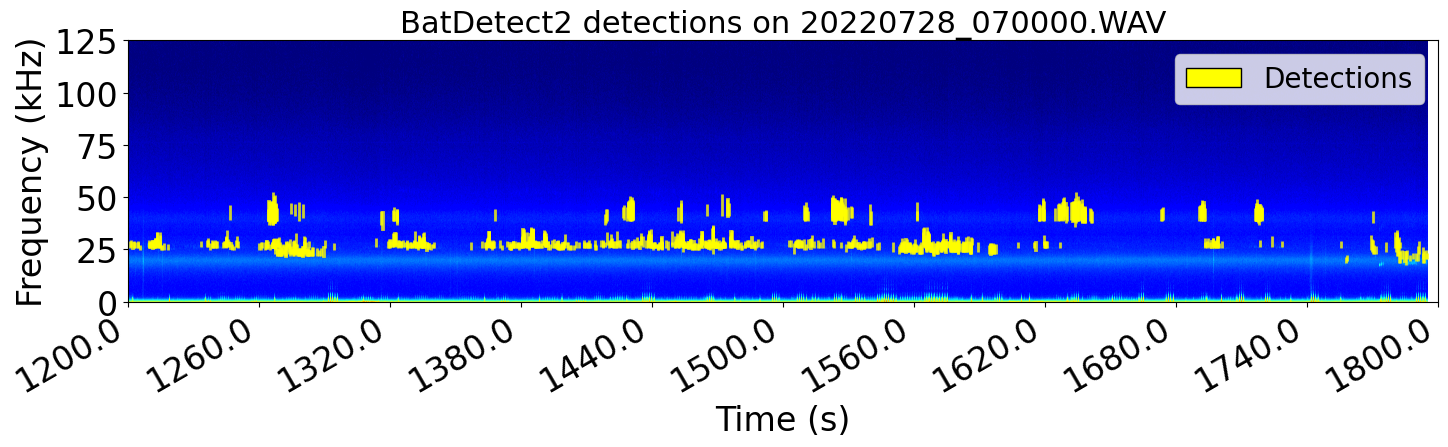

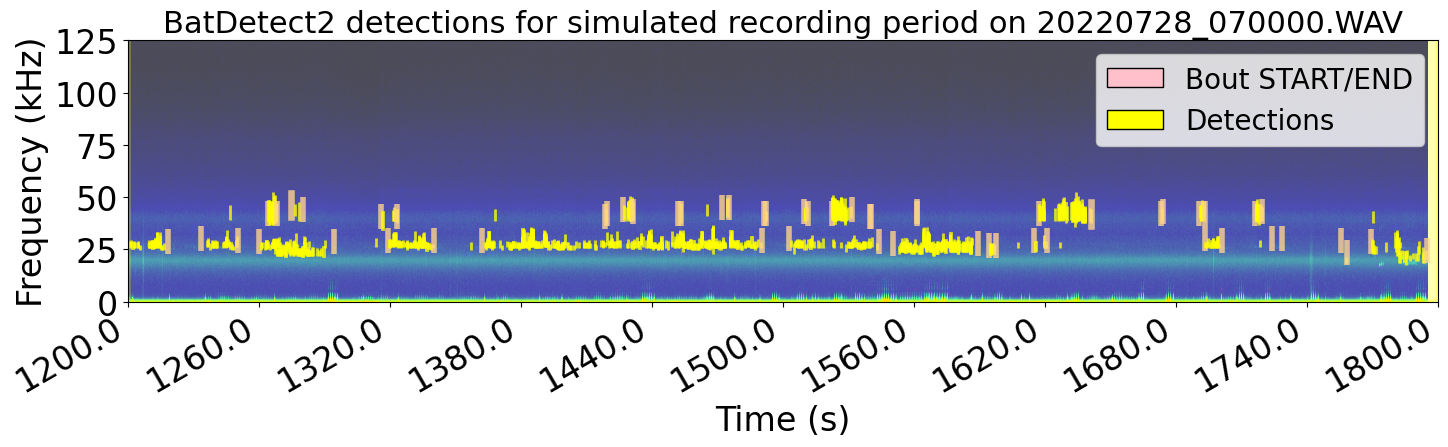

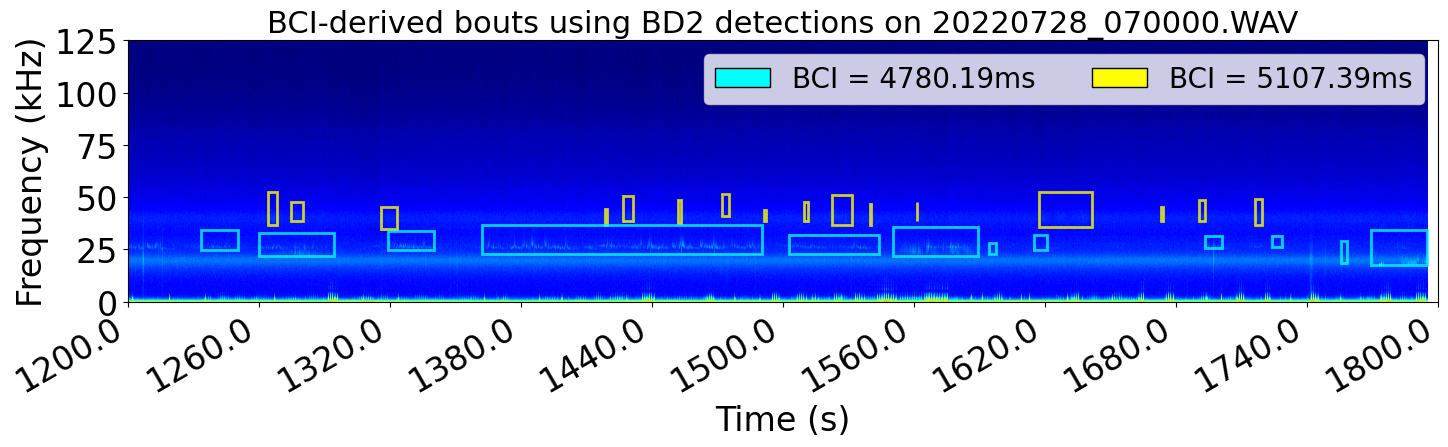

In [22]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)